In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras-self-attention

In [14]:
import itertools
import operator
import re
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import keras.backend as K
from keras import regularizers
from keras.preprocessing import sequence, text
from keras.models import Sequential, Model, load_model
from keras.layers import (Conv1D, Dense, Embedding, LSTM, SpatialDropout1D, Input, Activation, Dropout, GRU,
                          BatchNormalization, Flatten, concatenate, GlobalMaxPooling1D, MaxPooling1D)
from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

from keras_self_attention import SeqSelfAttention

from sklearn.model_selection import train_test_split
from sklearn.utils import resample, shuffle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

import warnings
warnings.filterwarnings("ignore")

plt.rcdefaults()

labels = ['Negative', 'Positive'] # 0:N 1:P
classes = ('Negative', 'Neutral', 'Positive')

# Parameters
max_fatures = 2000
embed_dim = 128
batch_size = 128
random_state = 42

## download kaggle first-gop-debate-twitter-sentiment dataset
Original Source: https://data.world/socialmediadata/first-gop-debate-twitter

In [2]:
! pip install -q kaggle

In [3]:
# upload kaggle json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amin2013","key":"8f9c6405131dee52ebcfd323e9c441f2"}'}

In [4]:
 ! mkdir ~/.kaggle

In [5]:
 ! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d crowdflower/first-gop-debate-twitter-sentiment

  0% 0.00/2.40M [00:00<?, ?B/s]
100% 2.40M/2.40M [00:00<00:00, 78.9MB/s]


In [8]:
!unzip first-gop-debate-twitter-sentiment.zip

Archive:  first-gop-debate-twitter-sentiment.zip
  inflating: Sentiment.csv           
  inflating: database.sqlite         


##Data Prepration

In [9]:
data = pd.read_csv('/content/Sentiment.csv')
data = data[['text','sentiment']]
data.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


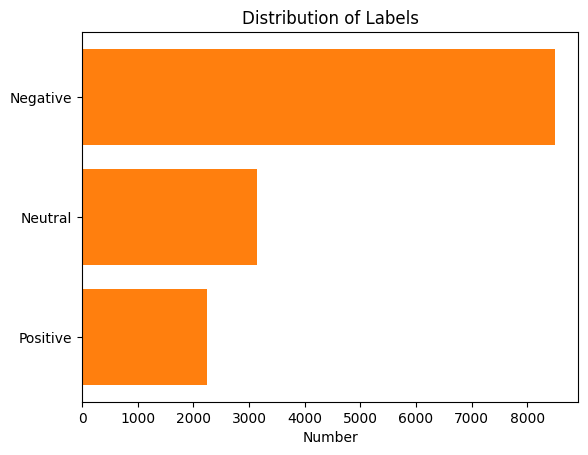

Negative    8493
Neutral     3142
Positive    2236
Name: sentiment, dtype: int64


In [ ]:
fig, ax = plt.subplots()
classes = ('Negative', 'Neutral', 'Positive')
y_pos = np.arange(len(classes))
dist = data.sentiment.value_counts(sort=True)
error = np.random.rand(len(classes))

ax.barh(y_pos, dist, xerr=error, align='center')
ax.barh(y_pos, dist, xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(classes)
ax.invert_yaxis()
ax.set_xlabel('Number')
ax.set_title('Distribution of Labels')
plt.show()
print(dist)

In [11]:
# Drop Neutral class
data = data[data.sentiment != "Neutral"]
# Convert all text to lower case
data['text'] = data['text'].apply(lambda x: x.lower())
# Removing special chars
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
data.head()

,text,sentiment
1,rt scottwalker didnt catch the full gopdebate ...,Positive
3,rt robgeorge that carly fiorina is trending h...,Positive
4,rt danscavino gopdebate w realdonaldtrump deli...,Positive
5,rt gregabbott_tx tedcruz on my first day i wil...,Positive
6,rt warriorwoman91 i liked her and was happy wh...,Negative


In [12]:
for idx,row in data.iterrows():
    row[0] = row[0].replace('rt','')
data.head()

,text,sentiment
1,scottwalker didnt catch the full gopdebate la...,Positive
3,robgeorge that carly fiorina is trending hou...,Positive
4,danscavino gopdebate w realdonaldtrump delive...,Positive
5,gregabbott_tx tedcruz on my first day i will ...,Positive
6,warriorwoman91 i liked her and was happy when...,Negative


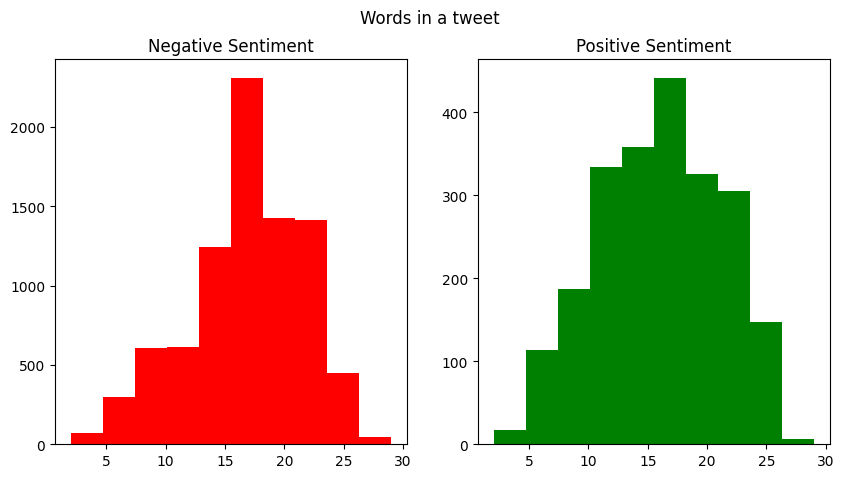

In [ ]:
x = data.sentiment.value_counts()

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
neg_data_len=data[data.sentiment=='Negative']['text'].str.split().map(lambda x: len(x))
ax1.hist(neg_data_len,color='red')
ax1.set_title('Negative Sentiment')
pos_data_len=data[data.sentiment=='Positive']['text'].str.split().map(lambda x: len(x))
ax2.hist(pos_data_len,color='green')
ax2.set_title('Positive Sentiment')
fig.suptitle('Words in a tweet')
plt.show()

In [15]:
tokenizer = text.Tokenizer(num_words=max_fatures, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = sequence.pad_sequences(X)
print(X[:3])
Y = pd.get_dummies(data['sentiment']).values
print(np.unique(Y))

[[   0    0    0    0    0    0    0    0    0    0    0  359  120    1
   692    2   39   58  234   37  207    6  172 1745   12 1308 1394  733]
 [   0    0    0    0    0    0    0    0    0    0    0   16  281  249
     5  809  102  170   26  134    6    1  171   12    2  231  713   17]
 [   0    0    0    0    0    0    0    0    0    0    0    0 1246    2
   300   23 1927    1 1613  214   12    1  693    6  183  204  366  678]]
[0 1]


In [18]:
word_index = tokenizer.word_index
sorted(word_index.items(), key=operator.itemgetter(1))[:100]

[('the', 1),
 ('gopdebate', 2),
 ('gopdebates', 3),
 ('to', 4),
 ('is', 5),
 ('of', 6),
 ('a', 7),
 ('and', 8),
 ('i', 9),
 ('rwsurfergirl', 10),
 ('you', 11),
 ('in', 12),
 ('it', 13),
 ('for', 14),
 ('trump', 15),
 ('that', 16),
 ('on', 17),
 ('fox', 18),
 ('not', 19),
 ('this', 20),
 ('was', 21),
 ('about', 22),
 ('realdonaldtrump', 23),
 ('amp', 24),
 ('news', 25),
 ('debate', 26),
 ('from', 27),
 ('have', 28),
 ('at', 29),
 ('we', 30),
 ('me', 31),
 ('but', 32),
 ('he', 33),
 ('be', 34),
 ('candidates', 35),
 ('just', 36),
 ('are', 37),
 ('like', 38),
 ('last', 39),
 ('they', 40),
 ('so', 41),
 ('gop', 42),
 ('dont', 43),
 ('megynkelly', 44),
 ('with', 45),
 ('all', 46),
 ('up', 47),
 ('what', 48),
 ('people', 49),
 ('jeb', 50),
 ('foxnews', 51),
 ('who', 52),
 ('my', 53),
 ('how', 54),
 ('as', 55),
 ('if', 56),
 ('bush', 57),
 ('night', 58),
 ('has', 59),
 ('no', 60),
 ('their', 61),
 ('by', 62),
 ('when', 63),
 ('can', 64),
 ('do', 65),
 ('one', 66),
 ('more', 67),
 ('im', 68),


##Data Split by using Holdout Method

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y ,test_size=0.2,random_state=random_state)
print('X Training: ',X_train.shape)
print('Y Training: ',Y_train.shape)
print('X Test: ',X_test.shape)
print('Y Test: ',Y_test.shape)
print(type(X_train))

X Training:  (8583, 28)
Y Training:  (8583, 2)
X Test:  (2146, 28)
Y Test:  (2146, 2)
<class 'numpy.ndarray'>


##Clusters using Dimensionality Reduction

In [ ]:
yh= np.argmax(Y, axis=1)

# T-SNE Implementation
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)

# PCA Implementation
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X)

# TruncatedSVD
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X)

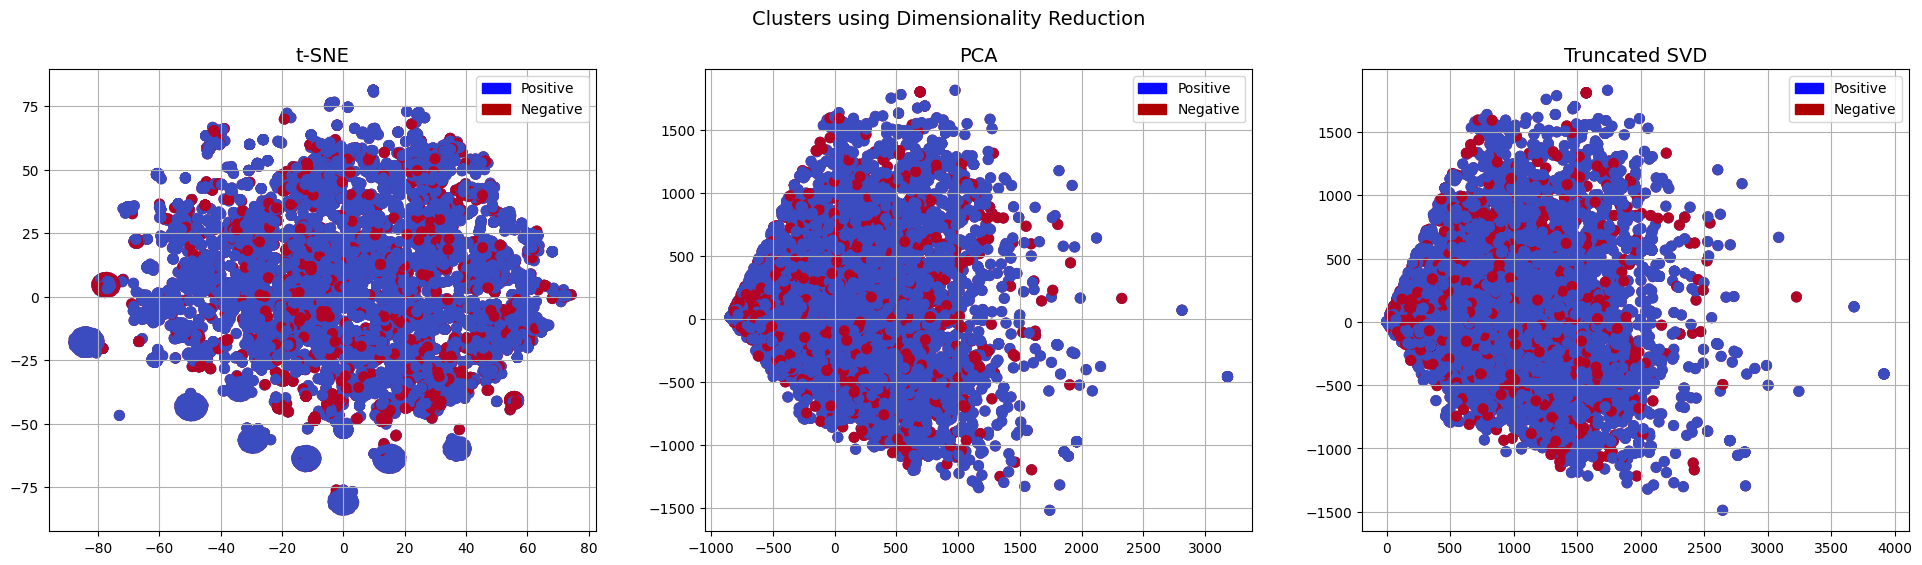

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))

f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='Positive')
red_patch = mpatches.Patch(color='#AF0000', label='Negative')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(yh == 0), cmap='coolwarm', label='Negative', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(yh == 1), cmap='coolwarm', label='Positive', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(yh == 0), cmap='coolwarm', label='Negative', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(yh == 1), cmap='coolwarm', label='Positive', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(yh == 0), cmap='coolwarm', label='Negative', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(yh == 1), cmap='coolwarm', label='Positive', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

##Confusion Matrix

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

##Model with Attention Mechanism

In [ ]:
def AttentionNet(input_shape, weightsPath=None):
    
    X_input=Input(input_shape)
    embedding = Embedding(max_fatures, embed_dim, embeddings_regularizer=regularizers.l2(0.001))(X_input)

    XI = Conv1D(64, 3, padding='same')(embedding)
    XI = Activation('relu')(XI)
    XI = BatchNormalization()(XI)

    XI = Conv1D(128, 3, padding='same')(XI)
    XI = Activation('relu')(XI)
    XI = BatchNormalization()(XI)

    XI = GRU(196, input_shape=(X_train.shape[0], X_train.shape[1]), return_sequences=True)(XI)
    # XI = LSTM(196, input_shape=(X_train.shape[0], X_train.shape[1]), return_sequences=True)(XI)
    XI = LayerNormalization(epsilon=1e-6)(XI)

    attn = SeqSelfAttention(attention_activation='sigmoid')(XI)
    
    Flat = Flatten()(attn)
    XI = Dense(2)(Flat)
    XI = Activation('softmax')(XI)

    model=Model(inputs=X_input,outputs=XI,name='CompactNet')

    if weightsPath is not None:
        model.load_weights(weightsPath)

    return model

model = AttentionNet(X.shape[1])
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001, amsgrad=True),
              metrics=['accuracy'])

Model: "CompactNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 28)]              0         
                                                                 
 embedding_10 (Embedding)    (None, 28, 128)           256000    
                                                                 
 conv1d_19 (Conv1D)          (None, 28, 64)            24640     
                                                                 
 activation_24 (Activation)  (None, 28, 64)            0         
                                                                 
 batch_normalization_7 (Batc  (None, 28, 64)           256       
 hNormalization)                                                 
                                                                 
 conv1d_20 (Conv1D)          (None, 28, 128)           24704     
                                                        

In [ ]:
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy',
                               cooldown=0, patience=5, min_lr=1e-7,
                               factor=0.1, verbose=1)
history = model.fit(X_train, Y_train, epochs = 30,
          validation_split=0.15,
          batch_size=batch_size,
          verbose = 1,
          callbacks=[lr_reducer])

Epoch 1/30
57/57 [==============================] - 21s 301ms/step - loss: 0.2839 - accuracy: 0.7563 - val_loss: 0.7452 - val_accuracy: 0.7787 - lr: 0.0010
Epoch 2/30
57/57 [==============================] - 16s 287ms/step - loss: 0.1230 - accuracy: 0.8780 - val_loss: 0.5625 - val_accuracy: 0.7787 - lr: 0.0010
Epoch 3/30
57/57 [==============================] - 16s 286ms/step - loss: 0.0849 - accuracy: 0.9261 - val_loss: 0.6838 - val_accuracy: 0.7787 - lr: 0.0010
Epoch 4/30
57/57 [==============================] - 16s 283ms/step - loss: 0.0651 - accuracy: 0.9416 - val_loss: 0.7788 - val_accuracy: 0.7787 - lr: 0.0010
Epoch 5/30
57/57 [==============================] - 16s 283ms/step - loss: 0.0551 - accuracy: 0.9493 - val_loss: 0.6887 - val_accuracy: 0.7787 - lr: 0.0010
Epoch 6/30
57/57 [==============================] - ETA: 0s - loss: 0.0470 - accuracy: 0.9501
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
57/57 [==============================] - 16s 

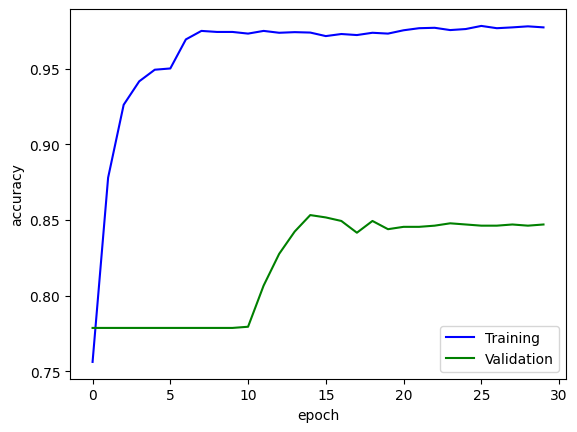

In [ ]:
plt.plot(history.history['accuracy'], 'b', label='Training')
plt.plot(history.history['val_accuracy'], 'g', label='Validation')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.savefig('acc_plot',dpi=100)
plt.show()

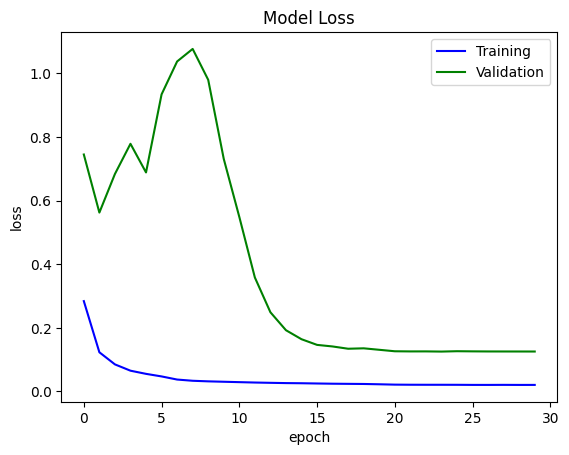

In [ ]:
plt.plot(history.history['loss'], 'b', label='Training')
plt.plot(history.history['val_loss'], 'g', label='Validation')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.savefig('loss_plot',dpi=100)
plt.show()

In [ ]:
scores = model.evaluate(X_test, Y_test, batch_size=32)
print("Test Loss: " + str(scores[0]))
print("Test Accuracy: " + str(scores[1]*100))

68/68 [==============================] - 2s 32ms/step - loss: 0.1183 - accuracy: 0.8546
Test Loss: 0.11828304827213287
Test Accuracy: 85.46132445335388


In [ ]:
yFlat = np.argmax(Y_test, axis=1)
yhat = model.predict(X_test)
yhatFlat= np.argmax(yhat, axis=1)
print(classification_report(yFlat, yhatFlat, target_names=labels, digits=4))

              precision    recall  f1-score   support

    Negative     0.8868    0.9375    0.9115      1713
    Positive     0.6806    0.5266    0.5938       433

    accuracy                         0.8546      2146
   macro avg     0.7837    0.7320    0.7526      2146
weighted avg     0.8452    0.8546    0.8474      2146



Confusion matrix, without normalization
[[1606  205]
 [ 107  228]]


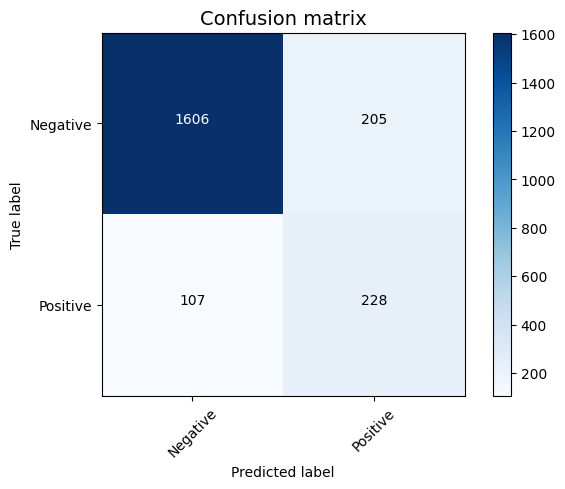

In [ ]:
actual_cm = confusion_matrix(yhatFlat, yFlat)
plot_confusion_matrix(actual_cm, labels, normalize=False)

##CNN Model without Spatial Dropout

In [29]:
def CompactNet(input_shape, weightsPath=None):
    
    X_input = Input(input_shape)
    embedding = Embedding(max_fatures, embed_dim, embeddings_regularizer=regularizers.l2(0.001))(X_input)

    conv1 = Conv1D(filters=200, kernel_size=2)(embedding)
    act1 = Activation('relu')(conv1)
    conv1 = BatchNormalization()(act1)

    conv2 = Conv1D(filters=200, kernel_size=3)(embedding)
    act2 = Activation('relu')(conv2)
    conv2 = BatchNormalization()(act2)

    conv3 = Conv1D(filters=200, kernel_size=4)(embedding)
    act3 = Activation('relu')(conv3)
    conv3 = BatchNormalization()(act3)
  
    pool1 = GlobalMaxPooling1D()(conv1)
    pool2 = GlobalMaxPooling1D()(conv2)
    pool3 = GlobalMaxPooling1D()(conv3)

    concat = concatenate([pool3, pool2, pool1])

    fc1 = Dense(30)(concat)
    drop1 = Dropout(0.5)(fc1)
    fc2 = Dense(2)(drop1)
    output = Activation('softmax')(fc2)

    model=Model(inputs=X_input,outputs=output,name='CompactNet')

    if weightsPath is not None:
        model.load_weights(weightsPath)

    return model

model = CompactNet(X_train.shape[1])
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001, amsgrad=True),
              metrics=['accuracy'])

Model: "CompactNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 28)]         0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 28, 128)      256000      ['input_7[0][0]']                
                                                                                                  
 conv1d_20 (Conv1D)             (None, 25, 200)      102600      ['embedding_6[0][0]']            
                                                                                                  
 conv1d_19 (Conv1D)             (None, 26, 200)      77000       ['embedding_6[0][0]']            
                                                                                         

In [ ]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               cooldown=0, patience=10, min_lr=1e-4,
                               factor=0.1, verbose=1)
history = model.fit(X_train, Y_train, epochs=10,
          validation_split=0.15,
          batch_size=batch_size,
          verbose=1,
          callbacks=[lr_reducer])

Epoch 1/10
57/57 [==============================] - 3s 27ms/step - loss: 0.8919 - accuracy: 0.7656 - val_loss: 0.7610 - val_accuracy: 0.8432 - lr: 0.0010
Epoch 2/10
57/57 [==============================] - 1s 22ms/step - loss: 0.4270 - accuracy: 0.8969 - val_loss: 0.7256 - val_accuracy: 0.8346 - lr: 0.0010
Epoch 3/10
57/57 [==============================] - 1s 22ms/step - loss: 0.3652 - accuracy: 0.9302 - val_loss: 0.6630 - val_accuracy: 0.8362 - lr: 0.0010
Epoch 4/10
57/57 [==============================] - 1s 24ms/step - loss: 0.3227 - accuracy: 0.9395 - val_loss: 0.6188 - val_accuracy: 0.8416 - lr: 0.0010
Epoch 5/10
57/57 [==============================] - 1s 23ms/step - loss: 0.2957 - accuracy: 0.9500 - val_loss: 0.5689 - val_accuracy: 0.8370 - lr: 0.0010
Epoch 6/10
57/57 [==============================] - 1s 23ms/step - loss: 0.2717 - accuracy: 0.9572 - val_loss: 0.5045 - val_accuracy: 0.8346 - lr: 0.0010
Epoch 7/10
57/57 [==============================] - 1s 22ms/step - loss: 0.2

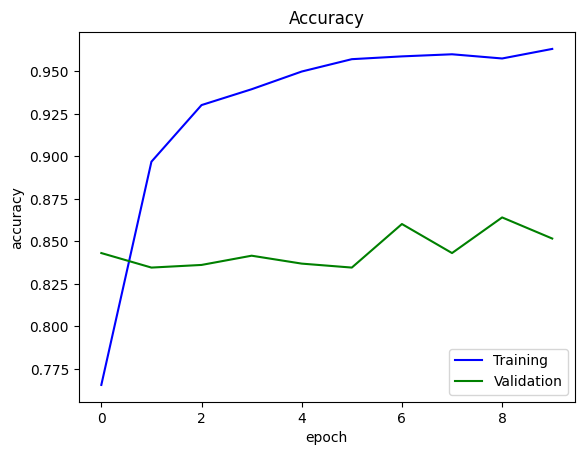

In [ ]:
plt.plot(history.history['accuracy'], 'b', label='Training')
plt.plot(history.history['val_accuracy'], 'g', label='Validation')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.savefig('acc_plot',dpi=100)
plt.show()

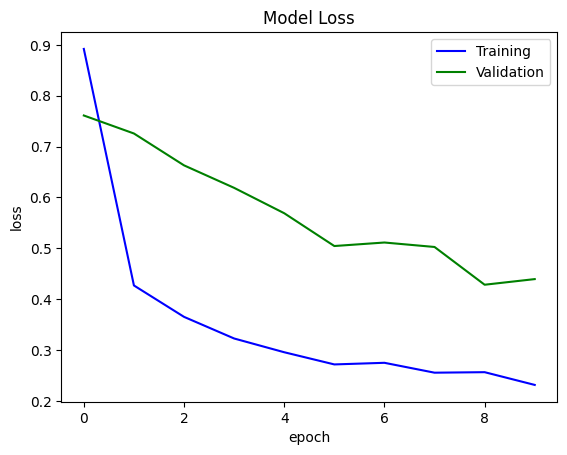

In [ ]:
plt.plot(history.history['loss'], 'b', label='Training')
plt.plot(history.history['val_loss'], 'g', label='Validation')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.savefig('loss_plot',dpi=100)
plt.show()

In [ ]:
scores = model.evaluate(X_test, Y_test, batch_size=32)
print("Test Loss: " + str(scores[0]))
print("Test Accuracy: " + str(scores[1]*100))

68/68 [==============================] - 0s 5ms/step - loss: 0.4498 - accuracy: 0.8611
Test Loss: 0.4497697949409485
Test Accuracy: 86.11369729042053


In [ ]:
yFlat = np.argmax(Y_test, axis=1)
yhat = model.predict(X_test)
yhatFlat= np.argmax(yhat, axis=1)
print(classification_report(yFlat, yhatFlat, target_names=labels, digits=4))

              precision    recall  f1-score   support

    Negative     0.8981    0.9317    0.9146      1713
    Positive     0.6829    0.5820    0.6284       433

    accuracy                         0.8611      2146
   macro avg     0.7905    0.7568    0.7715      2146
weighted avg     0.8547    0.8611    0.8569      2146



Confusion matrix, without normalization
[[1596  181]
 [ 117  252]]


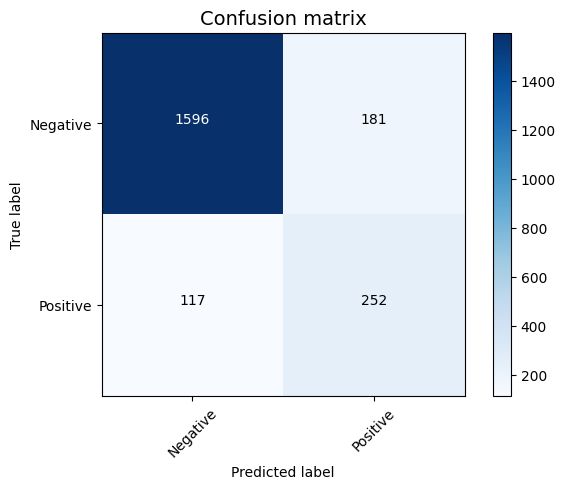

In [ ]:
actual_cm = confusion_matrix(yhatFlat, yFlat)
plot_confusion_matrix(actual_cm, labels, normalize=False)

##CNN Model (Best Model)

In [30]:
def CompactNet(input_shape, weightsPath=None):
    
    X_input = Input(input_shape)
    embedding = Embedding(max_fatures, embed_dim, embeddings_regularizer=regularizers.l2(0.001))(X_input)
    spdrop = SpatialDropout1D(0.2)(embedding)

    conv1 = Conv1D(filters=200, kernel_size=2)(spdrop)
    act1 = Activation('relu')(conv1)
    conv1 = BatchNormalization()(act1)

    conv2 = Conv1D(filters=200, kernel_size=3)(spdrop)
    act2 = Activation('relu')(conv2)
    conv2 = BatchNormalization()(act2)

    conv3 = Conv1D(filters=200, kernel_size=4)(spdrop)
    act3 = Activation('relu')(conv3)
    conv3 = BatchNormalization()(act3)
  
    pool1 = GlobalMaxPooling1D()(conv1)
    pool2 = GlobalMaxPooling1D()(conv2)
    pool3 = GlobalMaxPooling1D()(conv3)

    concat = concatenate([pool3, pool2, pool1])

    fc1 = Dense(30)(concat)
    fc2 = Dense(2)(fc1)
    output = Activation('softmax')(fc2)

    model=Model(inputs=X_input,outputs=output,name='CompactNet')

    if weightsPath is not None:
        model.load_weights(weightsPath)

    return model

model = CompactNet(X_train.shape[1])
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001, amsgrad=True),
              metrics=['accuracy'])

Model: "CompactNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 28)]         0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 28, 128)      256000      ['input_8[0][0]']                
                                                                                                  
 spatial_dropout1d_6 (SpatialDr  (None, 28, 128)     0           ['embedding_7[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 conv1d_23 (Conv1D)             (None, 25, 200)      102600      ['spatial_dropout1d_6[0]

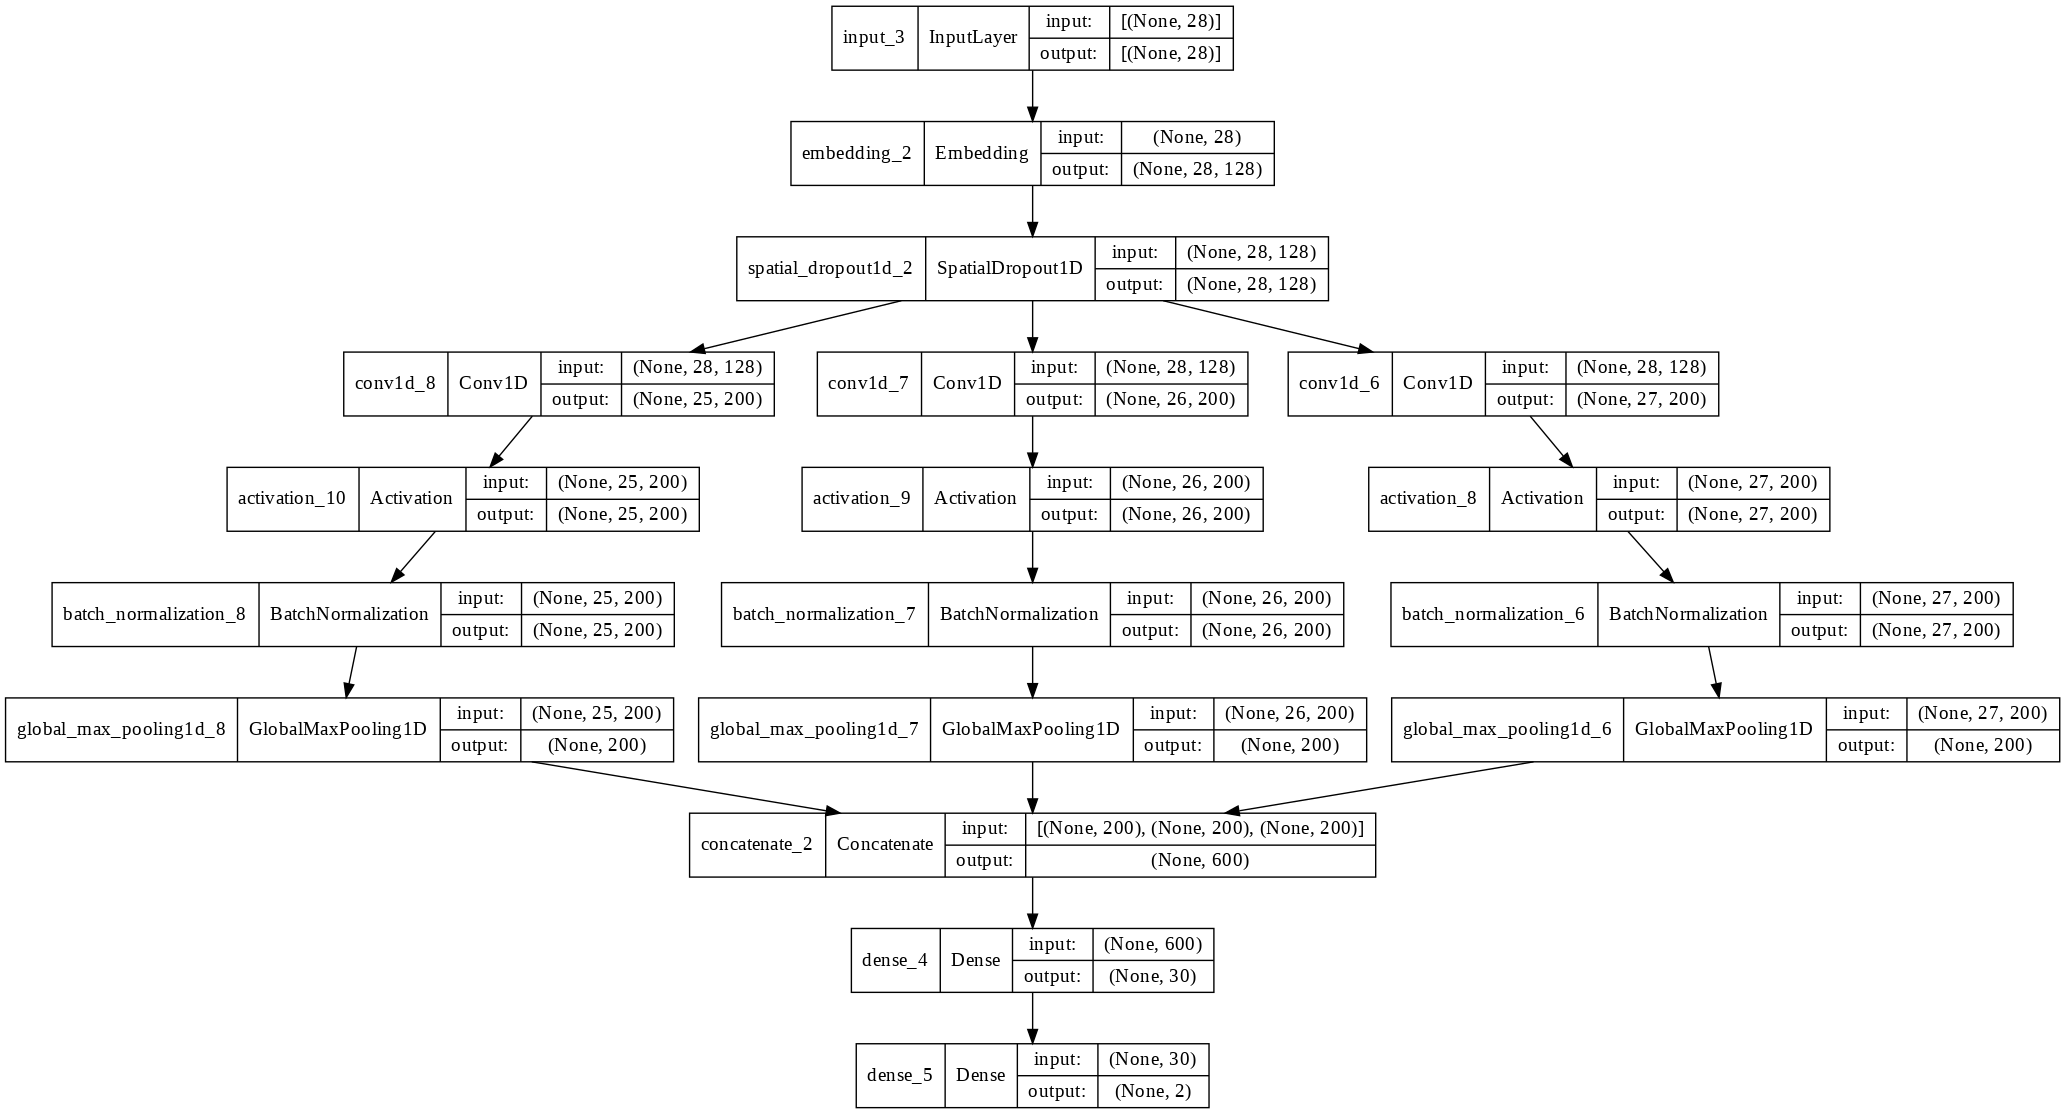

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, dpi=100)

In [ ]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               cooldown=0, patience=10, min_lr=1e-4,
                               factor=0.1, verbose=1)
history = model.fit(X_train, Y_train, epochs=40,
          validation_split=0.15,
          batch_size=batch_size,
          verbose=1,
          callbacks=[lr_reducer])

Epoch 1/40
57/57 [==============================] - 3s 28ms/step - loss: 0.7927 - accuracy: 0.7919 - val_loss: 0.7484 - val_accuracy: 0.8377 - lr: 0.0010
Epoch 2/40
57/57 [==============================] - 1s 24ms/step - loss: 0.3869 - accuracy: 0.8969 - val_loss: 0.7041 - val_accuracy: 0.8292 - lr: 0.0010
Epoch 3/40
57/57 [==============================] - 1s 23ms/step - loss: 0.3086 - accuracy: 0.9332 - val_loss: 0.6661 - val_accuracy: 0.8455 - lr: 0.0010
Epoch 4/40
57/57 [==============================] - 1s 24ms/step - loss: 0.2687 - accuracy: 0.9497 - val_loss: 0.6160 - val_accuracy: 0.8494 - lr: 0.0010
Epoch 5/40
57/57 [==============================] - 1s 22ms/step - loss: 0.2458 - accuracy: 0.9565 - val_loss: 0.5616 - val_accuracy: 0.8494 - lr: 0.0010
Epoch 6/40
57/57 [==============================] - 1s 22ms/step - loss: 0.2341 - accuracy: 0.9559 - val_loss: 0.5290 - val_accuracy: 0.8649 - lr: 0.0010
Epoch 7/40
57/57 [==============================] - 1s 22ms/step - loss: 0.2

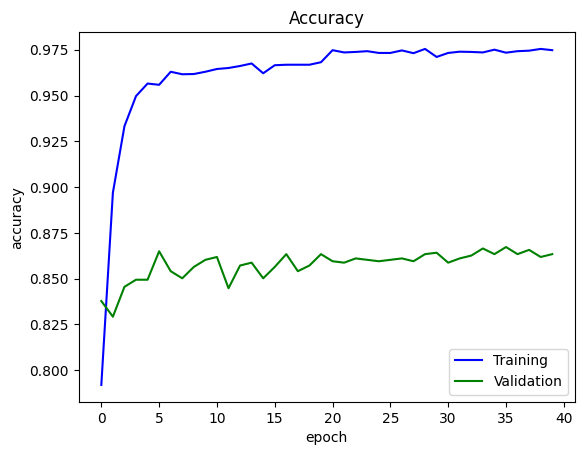

In [ ]:
plt.plot(history.history['accuracy'], 'b', label='Training')
plt.plot(history.history['val_accuracy'], 'g', label='Validation')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.savefig('acc_plot',dpi=100)
plt.show()

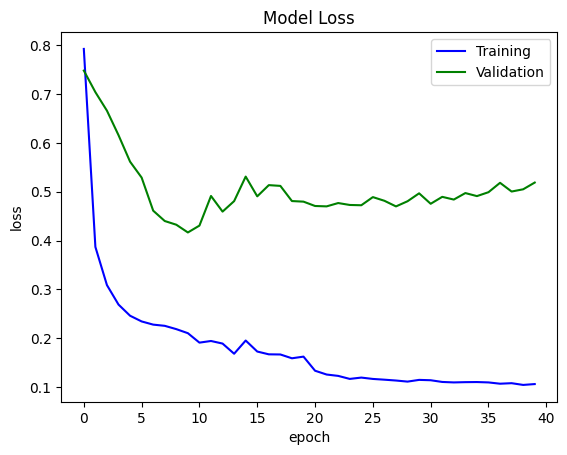

In [ ]:
plt.plot(history.history['loss'], 'b', label='Training')
plt.plot(history.history['val_loss'], 'g', label='Validation')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.savefig('loss_plot',dpi=100)
plt.show()

In [ ]:
scores = model.evaluate(X_test, Y_test, batch_size=32)
print("Test Loss: " + str(scores[0]))
print("Test Accuracy: " + str(scores[1]*100))

68/68 [==============================] - 0s 5ms/step - loss: 0.5422 - accuracy: 0.8630
Test Loss: 0.5422461628913879
Test Accuracy: 86.30009293556213


In [ ]:
yFlat = np.argmax(Y_test, axis=1)
yhat = model.predict(X_test)
yhatFlat= np.argmax(yhat, axis=1)
print(classification_report(yFlat, yhatFlat, target_names=labels, digits=4))

              precision    recall  f1-score   support

    Negative     0.8817    0.9568    0.9177      1713
    Positive     0.7422    0.4919    0.5917       433

    accuracy                         0.8630      2146
   macro avg     0.8119    0.7244    0.7547      2146
weighted avg     0.8535    0.8630    0.8519      2146



Confusion matrix, without normalization
[[1639  220]
 [  74  213]]


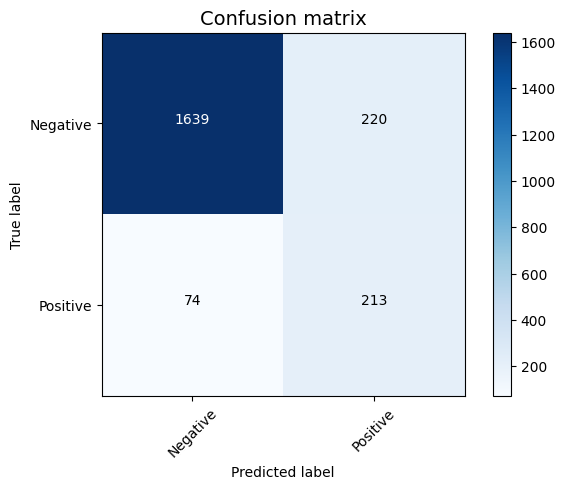

In [ ]:
actual_cm = confusion_matrix(yhatFlat, yFlat)
plot_confusion_matrix(actual_cm, labels, normalize=False)

##Under-sampling

In [19]:
df = data.sample(frac=1)


minority_class = df.loc[df['sentiment'] == 'Negative'][:2236]
majority_class = df.loc[df['sentiment'] == 'Positive']

normal_distributed_df = pd.concat([minority_class, majority_class])

new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,text,sentiment
2861,peddoc63 i lovedrealbencarson said he doesnt ...,Positive
1472,boffo early ratings for gopdebate 16 of us hou...,Positive
13766,ericstonestreet trump has cam hands gopdebates,Positive
4956,blahahaha the fix is on on the democrats side ...,Negative
8724,rwsurfergirl we the american people pick the ...,Negative


In [20]:
tokenizer = text.Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(new_df['text'].values)
X_full = tokenizer.texts_to_sequences(new_df['text'].values)
X_full = sequence.pad_sequences(X_full)
Y_full = pd.get_dummies(new_df['sentiment']).values

In [21]:
X_train_us, X_test_us, Y_train_us, Y_test_us = train_test_split(X_full, Y_full, test_size=0.2, random_state=42)
print('X Training: ',X_train_us.shape)
print('Y Training: ',Y_train_us.shape)
print('X Test: ',X_test_us.shape)
print('Y Test: ',Y_test_us.shape)

X Training:  (3577, 29)
Y Training:  (3577, 2)
X Test:  (895, 29)
Y Test:  (895, 2)


In [23]:
def CompactNet(input_shape, weightsPath=None):
    
    X_input = Input(input_shape)
    embedding = Embedding(max_fatures, embed_dim, embeddings_regularizer=regularizers.l2(0.001))(X_input)
    spdrop = SpatialDropout1D(0.2)(embedding)

    conv1 = Conv1D(filters=200, kernel_size=2)(spdrop)
    act1 = Activation('relu')(conv1)
    conv1 = BatchNormalization()(act1)

    conv2 = Conv1D(filters=200, kernel_size=3)(spdrop)
    act2 = Activation('relu')(conv2)
    conv2 = BatchNormalization()(act2)

    conv3 = Conv1D(filters=200, kernel_size=4)(spdrop)
    act3 = Activation('relu')(conv3)
    conv3 = BatchNormalization()(act3)
  
    pool1 = GlobalMaxPooling1D()(conv1)
    pool2 = GlobalMaxPooling1D()(conv2)
    pool3 = GlobalMaxPooling1D()(conv3)

    concat = concatenate([pool3, pool2, pool1])

    fc1 = Dense(30)(concat)
    fc2 = Dense(2)(fc1)
    output = Activation('softmax')(fc2)

    model=Model(inputs=X_input,outputs=output,name='CompactNet')

    if weightsPath is not None:
        model.load_weights(weightsPath)

    return model

model = CompactNet(X_train_us.shape[1])
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001, amsgrad=True),
              metrics=['accuracy'])

Model: "CompactNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 29)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 29, 128)      256000      ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 29, 128)     0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 conv1d_2 (Conv1D)              (None, 26, 200)      102600      ['spatial_dropout1d[0][0

In [24]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               cooldown=0, patience=10, min_lr=1e-8,
                               factor=0.1, verbose=1)
history = model.fit(X_train_us, Y_train_us, epochs = 40,
          validation_split=0.15,
          batch_size=batch_size,
          verbose = 1,
          callbacks=[lr_reducer])

Epoch 1/40
24/24 [==============================] - 12s 30ms/step - loss: 1.0061 - accuracy: 0.6313 - val_loss: 0.8217 - val_accuracy: 0.6257 - lr: 0.0010
Epoch 2/40
24/24 [==============================] - 0s 10ms/step - loss: 0.4804 - accuracy: 0.8615 - val_loss: 0.8072 - val_accuracy: 0.7281 - lr: 0.0010
Epoch 3/40
24/24 [==============================] - 0s 10ms/step - loss: 0.3595 - accuracy: 0.9345 - val_loss: 0.7940 - val_accuracy: 0.7709 - lr: 0.0010
Epoch 4/40
24/24 [==============================] - 0s 10ms/step - loss: 0.3034 - accuracy: 0.9533 - val_loss: 0.7782 - val_accuracy: 0.7542 - lr: 0.0010
Epoch 5/40
24/24 [==============================] - 0s 10ms/step - loss: 0.2687 - accuracy: 0.9632 - val_loss: 0.7633 - val_accuracy: 0.7616 - lr: 0.0010
Epoch 6/40
24/24 [==============================] - 0s 10ms/step - loss: 0.2477 - accuracy: 0.9697 - val_loss: 0.7442 - val_accuracy: 0.7728 - lr: 0.0010
Epoch 7/40
24/24 [==============================] - 0s 11ms/step - loss: 0.

In [25]:
scores = model.evaluate(X_test_us, Y_test_us, batch_size=32)
print("Test Loss: " + str(scores[0]))
print("Test Accuracy: " + str(scores[1]*100))

28/28 [==============================] - 0s 6ms/step - loss: 0.6506 - accuracy: 0.7810
Test Loss: 0.6506246328353882
Test Accuracy: 78.10055613517761


In [27]:
yFlat = np.argmax(Y_test_us, axis=1)
yhat = model.predict(X_test_us)
yhatFlat= np.argmax(yhat, axis=1)
print(classification_report(yFlat, yhatFlat, target_names=labels, digits=4))

              precision    recall  f1-score   support

    Negative     0.7738    0.7878    0.7808       443
    Positive     0.7883    0.7743    0.7812       452

    accuracy                         0.7810       895
   macro avg     0.7811    0.7811    0.7810       895
weighted avg     0.7811    0.7810    0.7810       895



Confusion matrix, without normalization
[[349 102]
 [ 94 350]]


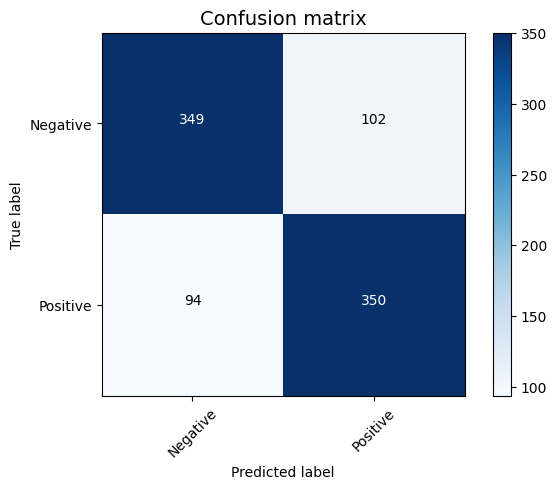

In [30]:
actual_cm = confusion_matrix(yhatFlat, yFlat)
plot_confusion_matrix(actual_cm, labels)

##Over-sampling

In [ ]:
majority_class = data[data.sentiment == 'Negative']
minority_class = data[data.sentiment == 'Positive']

bias = minority_class.shape[0]/majority_class.shape[0]

train_set = pd.concat([majority_class.sample(frac=0.8,random_state=random_state),
         minority_class.sample(frac=0.8,random_state=random_state)])
test_set = pd.concat([majority_class.drop(majority_class.sample(frac=0.8,random_state=random_state).index),
        minority_class.drop(minority_class.sample(frac=0.8,random_state=random_state).index)])

train = shuffle(train_set)
test = shuffle(test_set)

print('Training Set Distribution:\n', train.sentiment.value_counts(sort=True))
print('Testing Set Distribution:\n', test.sentiment.value_counts(sort=True))

Training set Distribution:
 Negative    6794
Positive    1789
Name: sentiment, dtype: int64
Testing set Distribution:
 Negative    1699
Positive     447
Name: sentiment, dtype: int64


In [ ]:
train_majority = train[train.sentiment == 'Negative']
train_minority = train[train.sentiment == 'Positive']

train_minority_upsampled = resample(train_minority, n_samples= train_majority.shape[0],random_state=random_state)
 
# Concatenate major and minor classes
data_oversampled = pd.concat([train_majority, train_minority_upsampled])
 
print("Training Set Distribution After Oversampling\n", data_oversampled.sentiment.value_counts())

Training Set Distribution After Oversampling
 Negative    6794
Positive    6794
Name: sentiment, dtype: int64


In [ ]:
tokenizer = text.Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)

X_train = tokenizer.texts_to_sequences(data_oversampled['text'].values)
X_train_os = sequence.pad_sequences(X_train)
Y_train_os = pd.get_dummies(data_oversampled['sentiment']).values
print('X Training:',X_train_os.shape)

X_test = tokenizer.texts_to_sequences(test['text'].values)
X_test_os = sequence.pad_sequences(X_test)
Y_test_os = pd.get_dummies(test['sentiment']).values
print("X Test:", X_test_os.shape)

X Training: (13588, 27)
X Test: (2146, 28)


In [ ]:
def CompactNet(input_shape, weightsPath=None):
    
    X_input=Input(input_shape)
    embedding = Embedding(max_fatures, embed_dim, embeddings_regularizer=regularizers.l2(0.001))(X_input)
    SPD = SpatialDropout1D(0.2)(embedding)

    conv1 = Conv1D(filters=200, kernel_size=2)(SPD)
    act1 = Activation('relu')(conv1)
    conv1 = BatchNormalization()(act1)
    conv2 = Conv1D(filters=200, kernel_size=3)(SPD)
    act2 = Activation('relu')(conv2)
    conv2 = BatchNormalization()(act2)
    conv3 = Conv1D(filters=200, kernel_size=4)(SPD)
    act3 = Activation('relu')(conv3)
    conv3 = BatchNormalization()(act3)
  
    pool1 = GlobalMaxPooling1D()(conv1)
    pool2 = GlobalMaxPooling1D()(conv2)
    pool3 = GlobalMaxPooling1D()(conv3)

    conc_layer = concatenate([pool3, pool2, pool1])

    fc_layer1 = Dense(units=30,name='FullyConnected')(conc_layer)
    predictions = Dense(2, activation='softmax')(fc_layer1)

    model=Model(inputs=X_input,outputs=predictions,name='CompactNet')

    if weightsPath is not None:
        model.load_weights(weightsPath)

    return model

model = CompactNet(X_train_os.shape[1])
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001, amsgrad=True),
              metrics=['accuracy'])

Model: "CompactNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None, 27)]         0           []                               
                                                                                                  
 embedding_39 (Embedding)       (None, 27, 128)      256000      ['input_39[0][0]']               
                                                                                                  
 spatial_dropout1d_17 (SpatialD  (None, 27, 128)     0           ['embedding_39[0][0]']           
 ropout1D)                                                                                        
                                                                                                  
 conv1d_109 (Conv1D)            (None, 24, 200)      102600      ['spatial_dropout1d_17[0

In [ ]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               cooldown=0, patience=10, min_lr=1e-4,
                               factor=0.1, verbose=1)
history = model.fit(X_train_os, Y_train_os, epochs=40,
          validation_split=0.15,
          batch_size=batch_size,
          verbose=1,
          class_weight={ 0: 1 , 1: 1.6/bias },
          callbacks=[lr_reducer])

Epoch 1/40
91/91 [==============================] - 4s 28ms/step - loss: 1.4681 - accuracy: 0.6802 - val_loss: 0.7276 - val_accuracy: 0.9819 - lr: 0.0010
Epoch 2/40
91/91 [==============================] - 2s 23ms/step - loss: 0.6907 - accuracy: 0.8713 - val_loss: 0.6711 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 3/40
91/91 [==============================] - 2s 22ms/step - loss: 0.5358 - accuracy: 0.9205 - val_loss: 0.5396 - val_accuracy: 0.9779 - lr: 0.0010
Epoch 4/40
91/91 [==============================] - 2s 23ms/step - loss: 0.4903 - accuracy: 0.9365 - val_loss: 0.5241 - val_accuracy: 0.9529 - lr: 0.0010
Epoch 5/40
91/91 [==============================] - 2s 22ms/step - loss: 0.4764 - accuracy: 0.9434 - val_loss: 0.3432 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 6/40
91/91 [==============================] - 2s 23ms/step - loss: 0.4970 - accuracy: 0.9437 - val_loss: 0.5568 - val_accuracy: 0.9147 - lr: 0.0010
Epoch 7/40
91/91 [==============================] - 2s 22ms/step - loss: 0.4

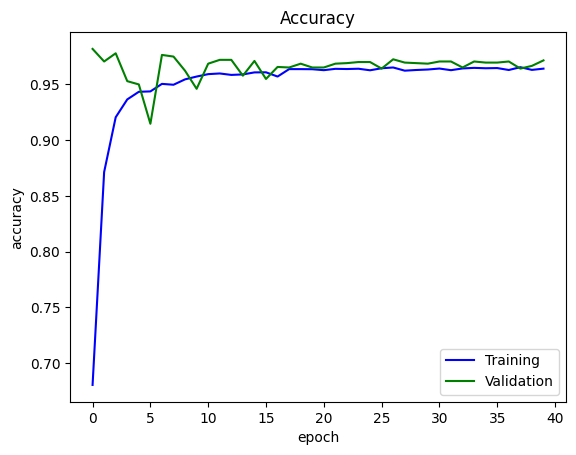

In [ ]:
plt.plot(history.history['accuracy'], 'b', label='Training')
plt.plot(history.history['val_accuracy'], 'g', label='Validation')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.savefig('acc_plot',dpi=100)
plt.show()

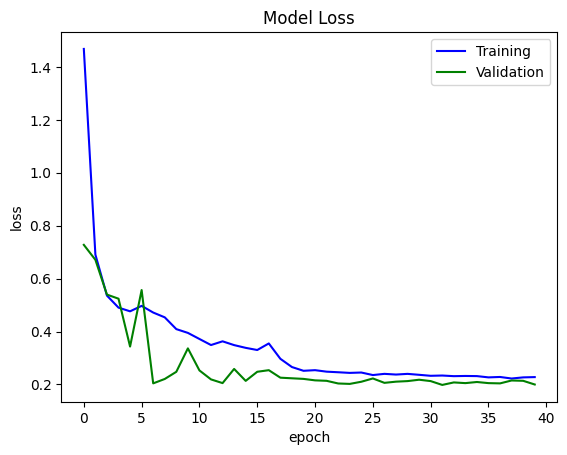

In [ ]:
plt.plot(history.history['loss'], 'b', label='Training')
plt.plot(history.history['val_loss'], 'g', label='Validation')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.savefig('loss_plot',dpi=100)
plt.show()

In [ ]:
scores = model.evaluate(X_test_os, Y_test_os, batch_size=32)
print("Test Loss: " + str(scores[0]))
print("Test Accuracy: " + str(scores[1]*100))

68/68 [==============================] - 0s 5ms/step - loss: 0.5967 - accuracy: 0.8308
Test Loss: 0.596662163734436
Test Accuracy: 83.08480978012085


In [ ]:
yFlat = np.argmax(Y_test_os, axis=1)
yhat = model.predict(X_test_os)
yhatFlat= np.argmax(yhat, axis=1)
print(classification_report(yFlat, yhatFlat, target_names=labels, digits=4))

              precision    recall  f1-score   support

    Negative     0.9139    0.8682    0.8904      1699
    Positive     0.5789    0.6890    0.6292       447

    accuracy                         0.8308      2146
   macro avg     0.7464    0.7786    0.7598      2146
weighted avg     0.8441    0.8308    0.8360      2146



Confusion matrix, without normalization
[[1475  139]
 [ 224  308]]


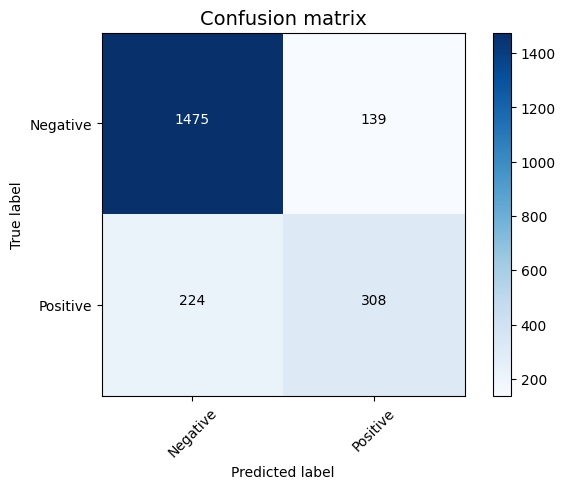

In [ ]:
actual_cm = confusion_matrix(yhatFlat, yFlat)
plot_confusion_matrix(actual_cm, labels, normalize=False)